## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline

import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cuda"

import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import _pickle as cPickle


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/root/anaconda3/envs/py37tf114/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7602 on context None
Mapped name None to device cuda: GeForce RTX 2070 SUPER (0000:01:00.0)
Using Theano backend.


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.04c_dict.dat",'rb'), encoding="latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  
            lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
print('Xsize=', X.shape)
print('lblsize=', np.shape(lbl))

Xsize= (90200, 2, 128)
lblsize= (90200, 2)


In [4]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [5]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(45100, 2, 128) [2, 128]


# Build the NN Model

In [6]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(64, (1,4), activation="relu"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(64, (2,4), activation="relu"))
model.add(Dropout(dr))
model.add(Conv2D(64, (1,8), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(dr))
model.add(Dense(len(classes), activation="softmax"))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

"""
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
"""

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 129, 64)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 129, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 133, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 130, 64)        32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 130, 64)       

'\nmodel.add(Convolution2D(256, 1, 3, border_mode=\'valid\', activation="relu", name="conv1", init=\'glorot_uniform\'))\nmodel.add(Dropout(dr))\nmodel.add(ZeroPadding2D((0, 2)))\nmodel.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init=\'glorot_uniform\'))\nmodel.add(Dropout(dr))\nmodel.add(Flatten())\nmodel.add(Dense(256, activation=\'relu\', init=\'he_normal\', name="dense1"))\nmodel.add(Dropout(dr))\nmodel.add(Dense( len(classes), init=\'he_normal\', name="dense2" ))\nmodel.add(Activation(\'softmax\'))\nmodel.add(Reshape([len(classes)]))\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\')\nmodel.summary()\n'

In [7]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [8]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 45100 samples, validate on 45100 samples
Epoch 1/100
 - 3s - loss: 2.2895 - accuracy: 0.1349 - val_loss: 2.1409 - val_accuracy: 0.1576

Epoch 00001: val_loss improved from inf to 2.14094, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 2/100
 - 3s - loss: 2.0709 - accuracy: 0.2019 - val_loss: 1.9175 - val_accuracy: 0.2867

Epoch 00002: val_loss improved from 2.14094 to 1.91754, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 3/100
 - 3s - loss: 1.8903 - accuracy: 0.2978 - val_loss: 1.7850 - val_accuracy: 0.3381

Epoch 00003: val_loss improved from 1.91754 to 1.78502, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 4/100
 - 3s - loss: 1.7645 - accuracy: 0.3379 - val_loss: 1.6490 - val_accuracy: 0.3625

Epoch 00004: val_loss improved from 1.78502 to 1.64901, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 5/100
 - 3s - loss: 1.6731 - accuracy: 0.3603 - val_loss: 1.5777 - val_accuracy: 0.3940

Epoch 00005: val_loss improved from 1.64901 to 1.57770, saving mode

# Evaluate and Plot Model Performance

In [9]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

[1.2489165434126892, 0.5177826881408691]


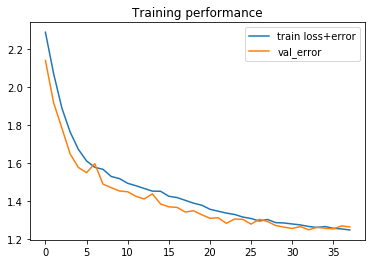

In [10]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [11]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

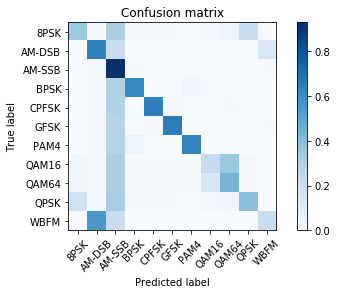

In [12]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.08848377056469542
Overall Accuracy:  0.09661399548532731
Overall Accuracy:  0.09964570416297608
Overall Accuracy:  0.10370697263901148
Overall Accuracy:  0.1305138699408822
Overall Accuracy:  0.18265845070422534
Overall Accuracy:  0.2687029659141213
Overall Accuracy:  0.415929203539823
Overall Accuracy:  0.6044543429844098
Overall Accuracy:  0.7177886758805172
Overall Accuracy:  0.7940647482014388
Overall Accuracy:  0.7603379279679857
Overall Accuracy:  0.7741792369121562
Overall Accuracy:  0.7828418230563002
Overall Accuracy:  0.7106890459363958
Overall Accuracy:  0.756021409455843
Overall Accuracy:  0.7899268187688334
Overall Accuracy:  0.7871051492860234
Overall Accuracy:  0.7394957983193278
Overall Accuracy:  0.7319223985890653


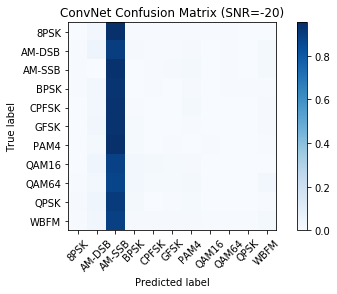

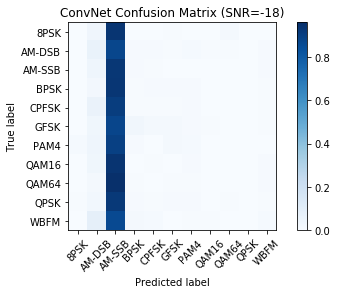

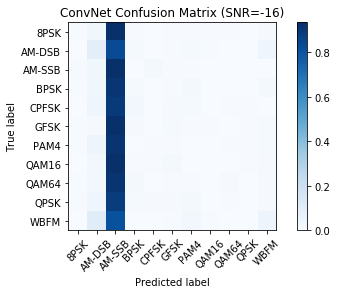

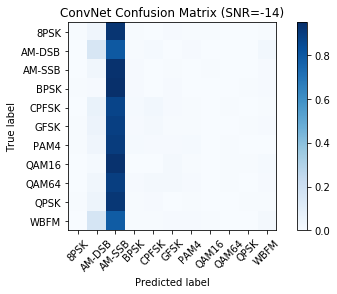

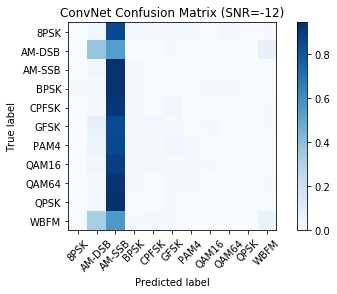

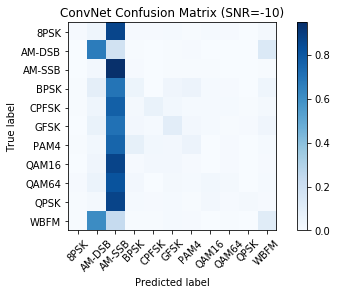

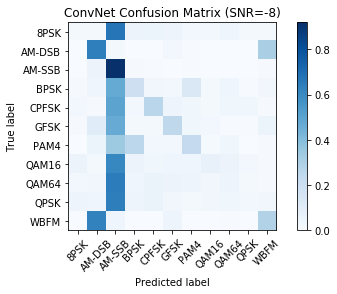

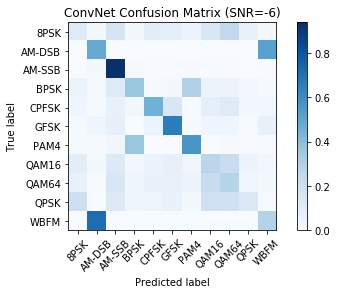

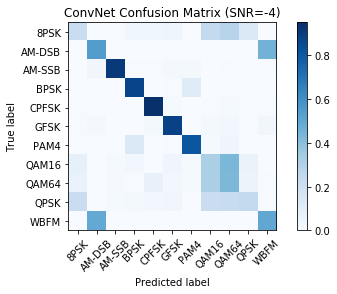

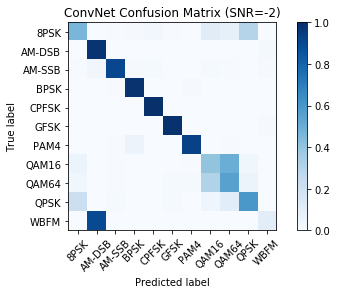

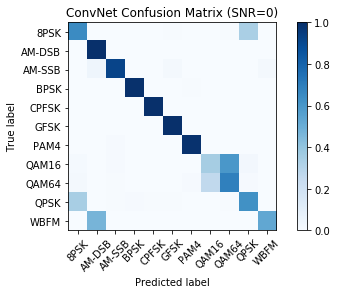

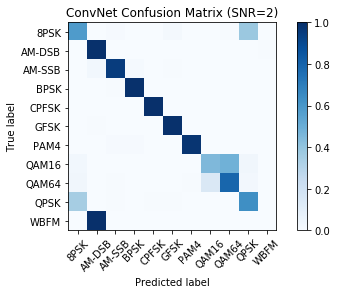

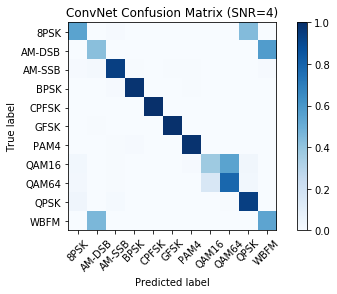

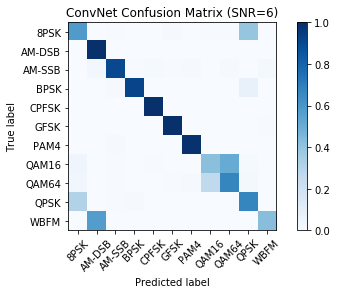

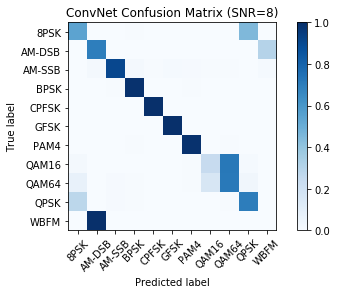

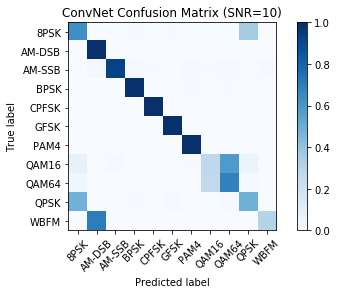

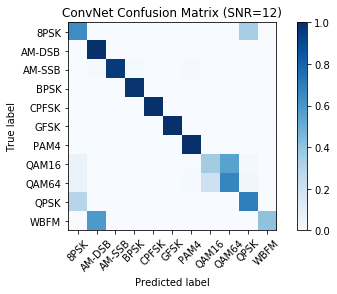

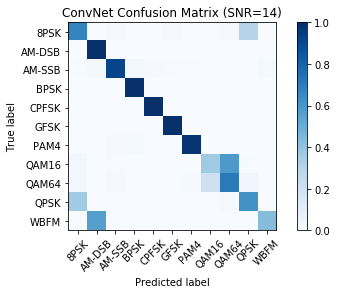

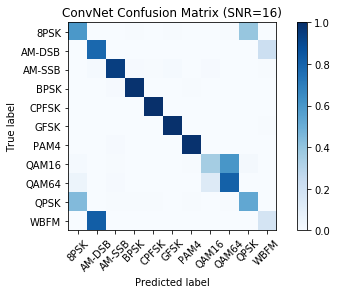

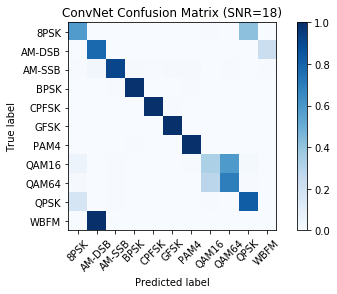

In [20]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)


In [21]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.08848377056469542, -18: 0.09661399548532731, -16: 0.09964570416297608, -14: 0.10370697263901148, -12: 0.1305138699408822, -10: 0.18265845070422534, -8: 0.2687029659141213, -6: 0.415929203539823, -4: 0.6044543429844098, -2: 0.7177886758805172, 0: 0.7940647482014388, 2: 0.7603379279679857, 4: 0.7741792369121562, 6: 0.7828418230563002, 8: 0.7106890459363958, 10: 0.756021409455843, 12: 0.7899268187688334, 14: 0.7871051492860234, 16: 0.7394957983193278, 18: 0.7319223985890653}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

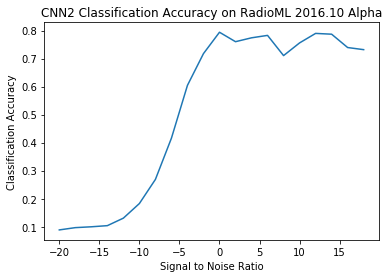

In [23]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")